### Условие задачи

<p>Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов! Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.</p>

### Описание услуг

<p>Оператор предоставляет два основных типа услуг:</p> 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

<p>Также доступны такие услуги:</p>

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

<p>За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.</p>

### Описание данных

<p>Данные состоят из файлов, полученных из разных источников:</p>

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 2 февраля 2021.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Меняем тип данных столбца TotalCharges.

In [5]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Убераем пропуски, которые получились после предыдущей операции.

In [6]:
contract.dropna(inplace=True)

Добавим к таблице contract столбец целевого признака, назовем его Status.

In [7]:
def func(enddate):
    if enddate == 'No':
        return 0
    else:
        return 1

In [8]:
contract['Status'] = contract['EndDate'].apply(func)

In [9]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

Берем из BeginDate месяц и день. Тут, как я понимаю не может быть утечки целевого признака. И у нас в любом случае есть дата заключения договора. 

Добавим столбец длительности взаимодействия.

In [12]:
def func1(enddate):
    if enddate == 'No':
        return '2020-02-01'
    else:
        return enddate

In [13]:
contract['EndDate'] = contract['EndDate'].apply(func1)

In [14]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

In [15]:
contract['Duration'] = contract['EndDate'] - contract['BeginDate']

In [16]:
contract['Duration'] = pd.to_numeric(contract['Duration'], errors='coerce') / 86400000000000

Соединим все наши таблицы.

In [17]:
general = contract.merge(personal, on='customerID', how='left')

In [18]:
general = general.merge(phone, on='customerID', how='left')

In [19]:
general = general.merge(internet, on='customerID', how='left')

Все пропуски заполним значением 'No'.

In [20]:
general = general.fillna('No')

Проврим есть ли в наших данных проблема мультиколлинеарности.

In [21]:
general.corr()

,MonthlyCharges,TotalCharges,Status,Duration,SeniorCitizen
MonthlyCharges,1.000000,0.651065,0.192858,0.246715,0.219874
TotalCharges,0.651065,1.000000,-0.199484,0.825811,0.102411
Status,0.192858,-0.199484,1.000000,-0.354496,0.150541
Duration,0.246715,0.825811,-0.354496,1.000000,0.015630
SeniorCitizen,0.219874,0.102411,0.150541,0.015630,1.000000


Высокая корреляция стобцов TotalCharges	и Duration - 0.82581. Столбец Duration мы добавили сами. Попробуем удалть TotalCharges.

Удалим столбцы 'BeginDate', 'EndDate', 'customerID'.

In [22]:
general = general.drop(['BeginDate', 'EndDate', 'customerID', 'TotalCharges'], axis=1) 

In [23]:
general_dum = pd.get_dummies(general, drop_first=True)

In [24]:
train_cat, test_cat = train_test_split(general, test_size=0.25, random_state=12345)
train, test = train_test_split(general_dum, test_size=0.25, random_state=12345)

In [25]:
features_train = train.drop('Status', axis=1)
target_train = train['Status']
features_test = test.drop('Status', axis=1)
target_test = test['Status']

In [26]:
features_train_cat = train_cat.drop('Status', axis=1)
target_train_cat = train_cat['Status']
features_test_cat = test_cat.drop('Status', axis=1)
target_test_cat = test_cat['Status']

Посмотрим разницу в количестве классов.

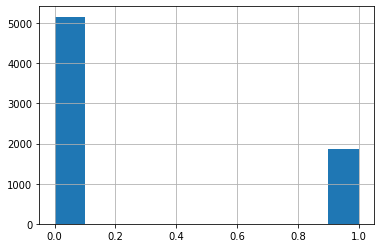

In [27]:
general_dum['Status'].hist()

Уравновесим наши классы.

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

In [29]:
features_upsampled_cat, target_upsampled_cat = upsample(features_train_cat, target_train_cat, 2)

In [30]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(features_test)
auc_roc = roc_auc_score(target_test, predicted)
print('AUCROC = ', auc_roc)

AUCROC =  0.7662101140134222


In [31]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, criterion='gini', min_samples_split=4,
                                    min_samples_leaf=1, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(features_test)
auc_roc = roc_auc_score(target_test, predicted)
print('AUCROC = ', auc_roc)

AUCROC =  0.7818102437442308


In [32]:
auc_roc_=0
i_=0
for i in range(2, 21, 1):
    model = DecisionTreeClassifier(max_depth=i, random_state=12345)
    model.fit(features_train, target_train)
    predicted = model.predict(features_test)
    auc_roc = roc_auc_score(target_test, predicted)
    if auc_roc_ < auc_roc:
        auc_roc_ = auc_roc
        i_=i
print('AUCROC = ', auc_roc_)

AUCROC =  0.7195269815133597


In [33]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod','gender', 'Partner',  'Dependents', 'MultipleLines', 'InternetService',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
model = CatBoostClassifier(loss_function="Logloss", depth=10, learning_rate=1, iterations=12)
model.fit(features_upsampled_cat, target_upsampled_cat, cat_features=cat_features, verbose=10)
predicted = model.predict_proba(features_test_cat)
predicted = predicted[:, 1]
auc_roc = roc_auc_score(target_test_cat, predicted)
print('AUCROC = ', auc_roc)

0:	learn: 0.5042248	total: 67.4ms	remaining: 741ms
10:	learn: 0.3534525	total: 571ms	remaining: 51.9ms
11:	learn: 0.3482236	total: 659ms	remaining: 0us
AUCROC =  0.8704879042653161


In [36]:
features_train.columns

Index(['MonthlyCharges', 'Duration', 'SeniorCitizen', 'Type_One year',
       'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes'],
      dtype='object')

In [34]:
predicted = predicted > 0.5

In [35]:
accuracy_score(target_test_cat, predicted)

0.800910125142207

AUCROC =  0.87, целевое значение получено. Бустинг для категориальных признаков показал себя лучше всего.